In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

In [37]:
# Sezione di analisi
# Caricamento dati e scelta dell'indice: per prima cosa carico il dataset e scelgo l'indice
df = pd.read_csv('/Users/veramalavolti/Desktop/Start2Impact/titanic_sub.csv')

In [39]:
df.shape

(891, 6)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Sex          891 non-null    object 
 2   Age          714 non-null    float64
 3   Pclass       891 non-null    int64  
 4   Embarked     889 non-null    object 
 5   Survived     891 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 41.9+ KB


In [43]:
df.describe(include=["object"])

,Sex,Embarked
count,891,889
unique,2,3
top,male,S
freq,577,644


In [45]:
df.head()

,PassengerId,Sex,Age,Pclass,Embarked,Survived
0,1,male,22.0,3,S,0
1,2,female,38.0,1,C,1
2,3,female,26.0,3,S,1
3,4,female,35.0,1,S,1
4,5,male,35.0,3,S,0


In [47]:
# Identifico quali colonne sono numeriche e quali sono categoriche
df.dtypes

PassengerId      int64
Sex             object
Age            float64
Pclass           int64
Embarked        object
Survived         int64
dtype: object

In [49]:
# Mi assicuro che "passengerId" sia univco per poterlo utilizare poi come indice.
df["PassengerId"].duplicated().sum()

0

In [51]:
# Scelgo come variabile che indicizzerà il dataframe il PassengerId
# Sceglgo il PassengerID perché è univoco per ogni passeggero e non ci sono info contenute utili per la previsione
if 'PassengerId' in df.columns:
    df.set_index('PassengerId', inplace=True)
else:
    df=df.reset_index(drop=True)

df.head()

,Sex,Age,Pclass,Embarked,Survived
PassengerId,,,,,
1,male,22.0,3,S,0
2,female,38.0,1,C,1
3,female,26.0,3,S,1
4,female,35.0,1,S,1
5,male,35.0,3,S,0


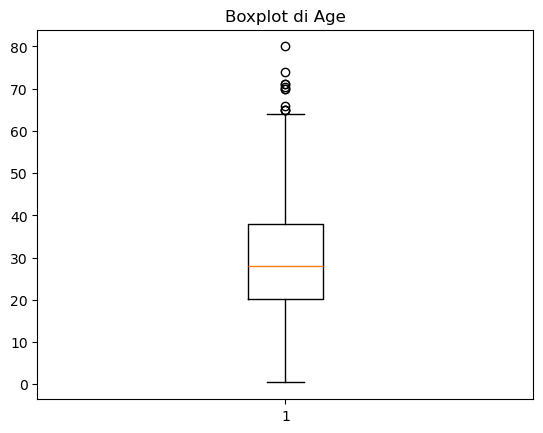

In [33]:
"""
    Il boxplot della variabile Age mostra la presenza di diversi valori anomali (outlier) nella parte alta della distribuzione,
    con età che superano i 70 anni. Questo vuol dire che se si decide di tenere la colonna Age è necessario utilizzare la mediana
    per poter sostituire i valori mancanti e per poter gestire
    al meglio la presenza degli outlier.
    
"""
import matplotlib.pyplot as plt

plt.boxplot(df["Age"].dropna())
plt.title("Boxplot di Age")
plt.show()


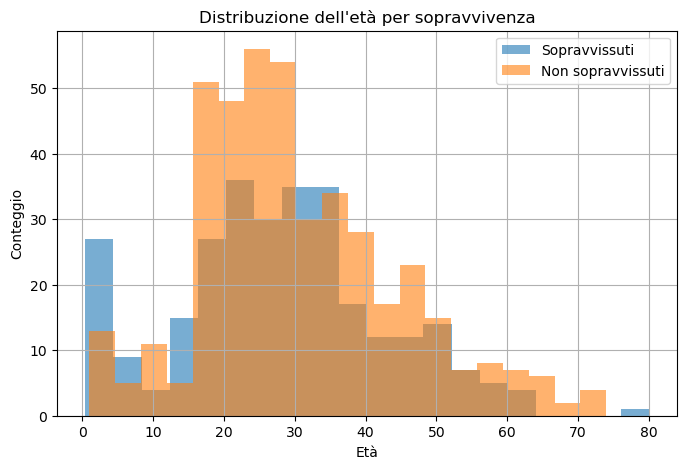

In [53]:
"""
   L’istogramma mostra la distribuzione dell’età per passeggeri sopravvissuti e non sopravvissuti.  
   Si nota che la distribuzione è simile tra i due gruppi, ma i bambini molto piccoli avevano maggiori possibilità di sopravvivere.
   Inoltre, la maggior parte degli adulti non sopravvissuti si concentra nella fascia 20-40 anni, 
   indicando che l’età da sola non è stata sufficiente a garantire la sopravvivenza.

"""

plt.figure(figsize=(8,5))
df[df["Survived"]==1]["Age"].hist(alpha=0.6, bins=20, label="Sopravvissuti")
df[df["Survived"]==0]["Age"].hist(alpha=0.6, bins=20, label="Non sopravvissuti")
plt.legend()
plt.xlabel("Età")
plt.ylabel("Conteggio")
plt.title("Distribuzione dell'età per sopravvivenza")
plt.show()

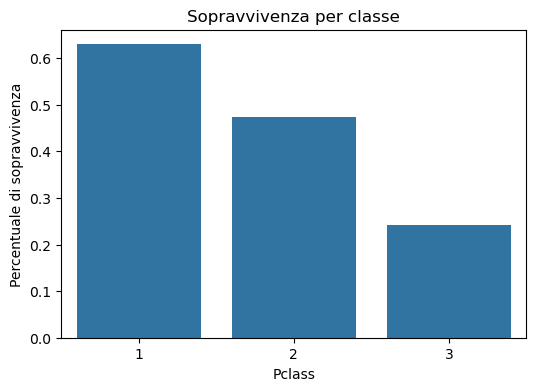

In [55]:
""" 
   Il grafico rappresenta la percentuale di sopravvivenza suddivisa per classe di viaggio.  
   I passeggeri di prima classe hanno avuto le maggiori probabilità di sopravvivenza (oltre il 60%), 
   seguiti da quelli di seconda classe (circa il 45%). I passeggeri di terza classe, invece, 
   hanno avuto la probabilità più bassa (circa il 25%). Questo mostra come la classe sociale influenzasse fortemente le possibilità di salvezza.
   
"""

import seaborn as sns

plt.figure(figsize=(6,4))
sns.barplot(x="Pclass", y="Survived", data=df, errorbar=None)
plt.ylabel("Percentuale di sopravvivenza")
plt.title("Sopravvivenza per classe")
plt.show()

In [57]:
"""
    Con questa tabella di contingenza (pd.crosstab) sto confrontando la variabile Sex con il target Survived,
    calcolando le proporzioni all’interno di ciascun gruppo di sesso.
    I valori mostrano che tra le donne circa il 74% è sopravvissuto, mentre tra gli uomini solo il 18,9% è sopravvissuto.
    Si deduce quindi che il sesso è una variabile fortemente correlata con la sopravvivenza.
    
"""

pd.crosstab(df["Sex"], df["Survived"], normalize="index")

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908


In [59]:
"""
    Conto i dati mancancanti di ogni colonna.
    
"""

df.isna().sum().sort_values(ascending=False)

Age         177
Embarked      2
Sex           0
Pclass        0
Survived      0
dtype: int64

In [65]:
"""
    Estraggo la colonna Survived e la converto in intero per sicurreza.
    Y è da prevedere (Survived) mentre X è il mio dataset.

"""
y = df['Survived'] # Non uso LabelEncoder e mantengo il target così come è, perchè + già 0/1
X = df.drop(columns=['Survived'])

X.head(), y.head()

(                Sex   Age  Pclass Embarked
 PassengerId                               
 1              male  22.0       3        S
 2            female  38.0       1        C
 3            female  26.0       3        S
 4            female  35.0       1        S
 5              male  35.0       3        S,
 PassengerId
 1    0
 2    1
 3    1
 4    1
 5    0
 Name: Survived, dtype: int64)

In [67]:
"""
    Faccio lo split prima del preprocessing per evitare il leakage
    Train/Test 75/25 -> uso stratify sulla variabile y per cercare di distribuire uniformemente y in ogni split
    
"""
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0, stratify=y
)
# Dal train: Train interno / Validation 75/25
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=0, stratify=y_train
)

print(f"\nDimensioni — Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")
print(f"Dimensioni — Train interno: {X_tr.shape[0]} | Validation: {X_val.shape[0]}")
print("\nDistribuzione target — FULL/TRAIN/TEST:",
      y.value_counts(normalize=True).round(3).to_dict(),
      y_train.value_counts(normalize=True).round(3).to_dict(),
      y_test.value_counts(normalize=True).round(3).to_dict())


Dimensioni — Train: 668 | Test: 223
Dimensioni — Train interno: 501 | Validation: 167

Distribuzione target — FULL/TRAIN/TEST: {0: 0.616, 1: 0.384} {0: 0.617, 1: 0.383} {0: 0.614, 1: 0.386}


In [85]:
"""
    Qui faccio imputazion corretta dei valori mancanti, codifico le categoriche in modo sicuro e incorporo tutto in un ColumTransformer dentro la Pipeline
    Per le numeriche: valido median e mean
    Perel categoriche: imputazione con most-frequent (invece di eliminare, o usare NaN per mantenere la consistenza) + OneHotEncoder invece di get_dummies (OneHotEncoder corretto per la Pipeline)
    Integrazione della correzione: garantisco che il modello impara solo dal training set + giustifico numericamente le scelte
"""
    
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(exclude=[np.number]).columns

# Uso la funzione make_preprocssor per considerare num_strategy (imputare i numerici) e with_imputers (se voglio applicare imputazione o fare altro)
# Come risultato ottendo un ColumnTransformer che applica pipeline diverse a num_cols e cat_cols
# Integro la correzione e cerco di valutare i due casi: 1. imputazione: uso tutti i dati con i valori stimati, 2. elimino le righe e uso meno dati, ma tutti dati reali
# Fatto questo, valuto l'impatto sui risultati (accuracy ecc) e giustifico numericamente la mia scelta
def make_preprocessor(num_strategy='median', with_imputers=True):
    if with_imputers:
        num_pipe = Pipeline(steps=[('imputer', SimpleImputer(strategy=num_strategy))])
        cat_pipe = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])
    else:
        num_pipe = 'passthrough'
        cat_pipe = OneHotEncoder(handle_unknown='ignore')
    return ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])

"""
    Valido un DecisionTreeClassifier al variare del parametro max_depth.
"""
def evaluate_depths(preprocessor, X_tr, y_tr, X_val, y_val, depths, random_state=0):
    scores = {}
    for d in depths:
        pipe = Pipeline([
            ('preprocess', preprocessor),
            ('model', DecisionTreeClassifier(max_depth=d, random_state=random_state))
        ])
        pipe.fit(X_tr, y_tr)
        preds = pipe.predict(X_val)
        scores[d] = accuracy_score(y_val, preds)
    return scores

""" 
    Rimuovo dal dataset le righe con valori mancanti in ogni colonna. 
    E' utile per confrontare la strategia Drop rispetto all'imputazione
"""
    
def drop_missing_pair(Xa, ya):
    mask = Xa.notna().all(axis=1)
    return Xa[mask], ya[mask]

"""La grglia di profondità da testare va da modelli molto semplici (2) a complessi (25), fino all'albero completo(None) """
depth_grid = [2, 5, 10, 25, None]

# Faccio l'analisi numerica
# A) median
preproc_median = make_preprocessor(num_strategy='median', with_imputers=True)
scores_median = evaluate_depths(preproc_median, X_tr, y_tr, X_val, y_val, depth_grid)
# B) mean
preproc_mean = make_preprocessor(num_strategy='mean', with_imputers=True)
scores_mean = evaluate_depths(preproc_mean, X_tr, y_tr, X_val, y_val, depth_grid)
# C) drop rows con missing (solo per analisi: sconsigliato spesso perché riduce i dati)
X_tr_drop, y_tr_drop = drop_missing_pair(X_tr, y_tr)
X_val_drop, y_val_drop = drop_missing_pair(X_val, y_val)
preproc_drop = make_preprocessor(with_imputers=False)
scores_drop = evaluate_depths(preproc_drop, X_tr_drop, y_tr_drop, X_val_drop, y_val_drop, depth_grid)

print("\nValidation accuracy (MEDIAN):", {k: round(v, 4) for k, v in scores_median.items()})
print("Validation accuracy (MEAN):  ", {k: round(v, 4) for k, v in scores_mean.items()})
print(f"Validation accuracy (DROP) [n_tr={len(X_tr_drop)}, n_val={len(X_val_drop)}]:",
      {k: round(v, 4) for k, v in scores_drop.items()})


Validation accuracy (MEDIAN): {2: 0.7665, 5: 0.7904, 10: 0.7844, 25: 0.7904, None: 0.7904}
Validation accuracy (MEAN):   {2: 0.7665, 5: 0.7904, 10: 0.7844, 25: 0.7904, None: 0.7904}
Validation accuracy (DROP) [n_tr=405, n_val=125]: {2: 0.784, 5: 0.8, 10: 0.8, 25: 0.8, None: 0.8}


In [87]:
"""
    Seleziono la coppia (strategia, max_depth) con accuracy migliore su validation
    In parità: preferisco la strategia che non riduce i dati
    Preferisco Median perché è più robusta agli outlier (coerente con la boxplot)
"""
def best_of(scores):
    best_depth = max(scores, key=scores.get) # seleziono la chiave con valore massimo (max_depth) e quindi con accuracy più alta
    return best_depth, scores[best_depth]

"""
    Applico best_of alle 3 varianti testate e ottengo 3 coppie, ognuna per ogni strategia
"""
best_median_depth, best_median_acc = best_of(scores_median)
best_mean_depth,   best_mean_acc   = best_of(scores_mean)
best_drop_depth,   best_drop_acc   = best_of(scores_drop)

"""
    Parto dal presupposto che la strategia predefinita è median, perché è più forte agli outlier, poi la confronto con mean
    Non ho incluso il drop perché riduce i dati e quindi aumenterei il rischio di bias e perdita di informazione (per questo motivo ho incluso il drop solo nella fase di valutazione, non nella selezione finale)
"""
chosen_strategy, chosen_depth, chosen_acc = 'median', best_median_depth, best_median_acc
if best_mean_acc > chosen_acc + 1e-6:
    chosen_strategy, chosen_depth, chosen_acc = 'mean', best_mean_depth, best_mean_acc


if best_drop_acc > chosen_acc + 0.01: # Considero drop solo se il vantaggio è netto
    pass

print(f"\nScelta finale: imputazione={chosen_strategy}, max_depth={chosen_depth} (val_acc={chosen_acc:.4f})")



Scelta finale: imputazione=median, max_depth=5 (val_acc=0.7904)


In [91]:
"""
    Faccio il retrain su train completo (train + val) e test finale
    Quindi: fit della pipeline finale su X_train e y_train
"""

#Costruisco il preprocessore finale (sclego la strategia di imputazione migliore - mean/drop/median - validata prima)
preprocessor_final = make_preprocessor(num_strategy=chosen_strategy, with_imputers=True)
# Costruisco la pipeline completa con il preprocessamento (imput + one_hot encoding) e il modello (decision tree e profondità ottimale)
final_pipe = Pipeline([
    ('preprocess', preprocessor_final),
    ('model', DecisionTreeClassifier(max_depth=chosen_depth, random_state=0))
])

# Addestro il modello finale su tutto il training set (train + validation) e aumento così la robustezza
final_pipe.fit(X_train, y_train)
# Misuro la capacità di generalizzazione sul test set tenuto da parte
test_preds = final_pipe.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)

# Calcolo la baseline più semplice possibile (classificatore che predice sempre la classe maggioritaria) e lo confronto con il nostro modello
baseline = y_train.value_counts(normalize=True).max()
print(f"\nTest accuracy (strategy={chosen_strategy}, depth={chosen_depth}): {test_acc:.4f}")
print(f"Baseline: {baseline:.4f}  |  Delta vs baseline: {test_acc - baseline:+.4f}")


Test accuracy (strategy=median, depth=5): 0.7713
Baseline: 0.6168  |  Delta vs baseline: +0.1545


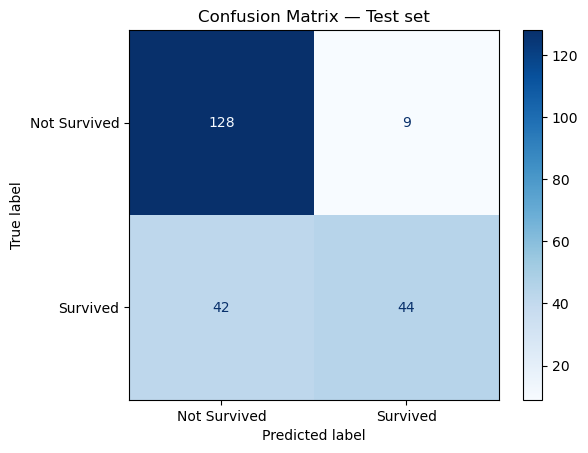


Classification report (Test):
              precision    recall  f1-score   support

Not Survived       0.75      0.93      0.83       137
    Survived       0.83      0.51      0.63        86

    accuracy                           0.77       223
   macro avg       0.79      0.72      0.73       223
weighted avg       0.78      0.77      0.76       223



In [93]:
"""
    Valutazione a posteriori
    Faccio la Confusion Matrix e il Classification report su Test
    Non valuto solo l'accuracy, ma anche quali errori commette il mdodello
""" 
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived','Survived'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix — Test set")
plt.show()

# Il modello è sbilanciato?
print("\nClassification report (Test):")
print(classification_report(y_test, test_preds, target_names=['Not Survived','Survived']))

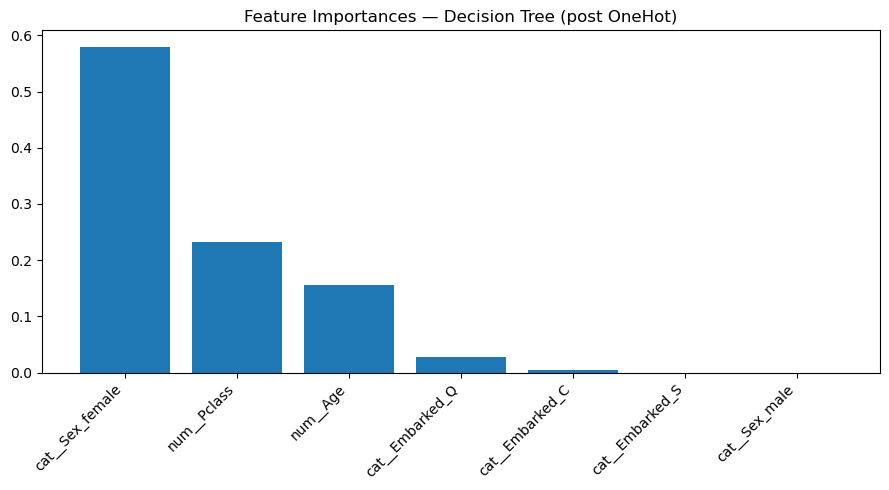


Top feature (5):
  1. cat__Sex_female: 0.580
  2. num__Pclass: 0.232
  3. num__Age: 0.156
  4. cat__Embarked_Q: 0.028
  5. cat__Embarked_C: 0.004


In [95]:
# Feature importances (faccio il mapping dei nomi dopo OneHot)
# NB: funziona perché il modello finale è un albero (ha feature_importances_)
model = final_pipe.named_steps['model']
try:
    feature_names = final_pipe.named_steps['preprocess'].get_feature_names_out()
except:
    # fallback: nomi generici se versione sklearn non supporta
    feature_names = np.array([f"f_{i}" for i in range(model.n_features_in_)])
importances = model.feature_importances_
order = np.argsort(importances)[::-1]

# Creo un grafico a barre per capire quali feature contano di più
plt.figure(figsize=(9,5))
plt.bar(range(len(importances)), importances[order])
plt.xticks(range(len(importances)), feature_names[order], rotation=45, ha='right')
plt.title("Feature Importances — Decision Tree (post OneHot)")
plt.tight_layout()
plt.show()

print("\nTop feature (5):")
for i in range(min(5, len(importances))):
    print(f"  {i+1}. {feature_names[order[i]]}: {importances[order[i]]:.3f}")

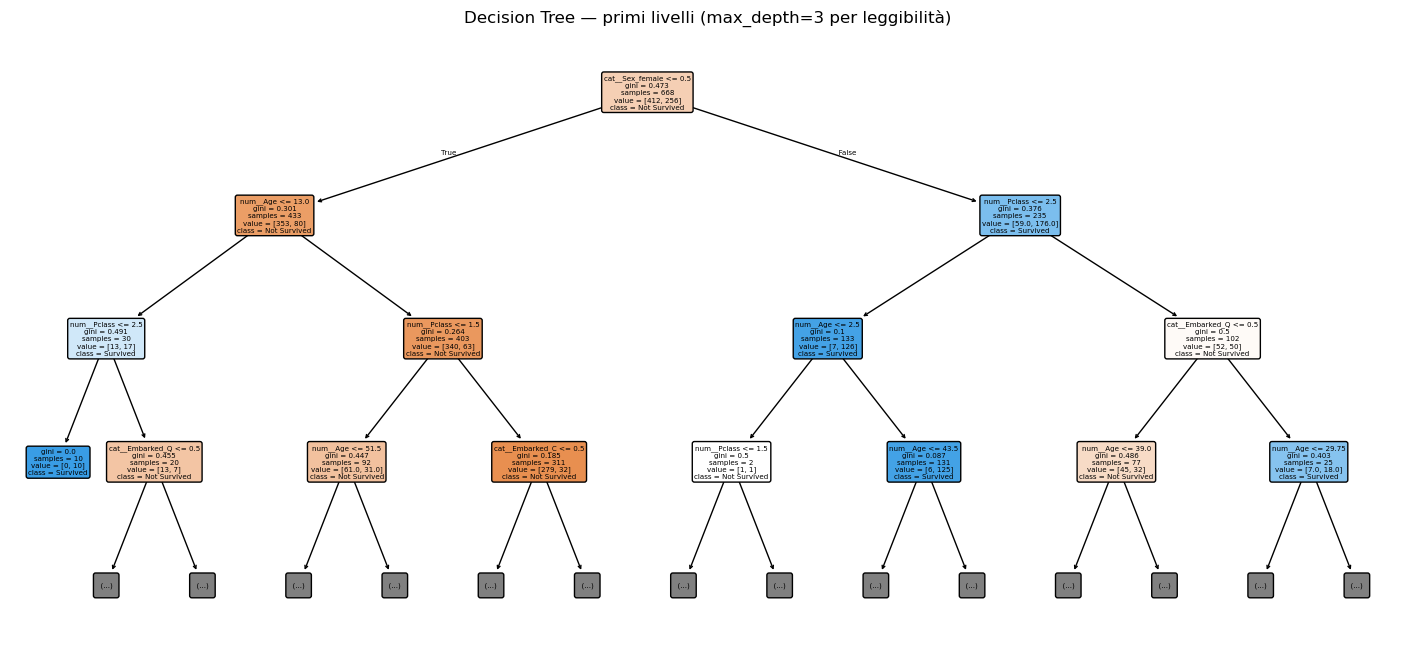

In [109]:
# Visualizzo direttamente le prime 5 feature, ordinate (sintesi rapida)
plt.figure(figsize=(18, 8))
plot_tree(model,
          feature_names=feature_names,
          class_names=['Not Survived','Survived'],
          filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree — primi livelli (max_depth=3 per leggibilità)")
plt.show()

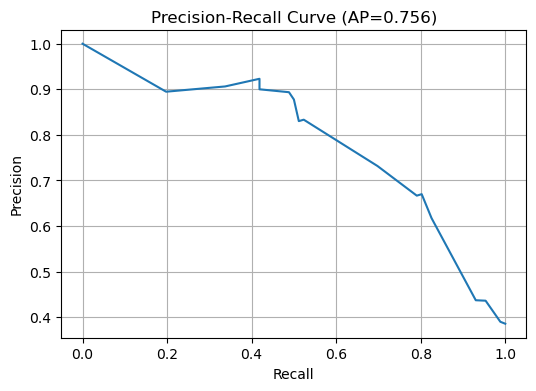

In [127]:
"""
    Valutazione finale: non mi limito all’accuracy, ma analizzo anche la curva precision–recall e l’effetto della soglia di decisione sul comportamento del modello.
    Accuracy non è sufficiente, percè potrebbe mascherare comportamenti sbilanciati
    Precision e recall catturano meglio i trade-off (più di ROC) tra Falsi Positivi e Falsi Negativi in dataset sbilanciati
    Il DecisioTreeClassifier mi dà probabilità predette per ogni classe, quindi posso variare la soglia e ottimizzare il bilanciamento Precision vs Recall (meglio di lavorare con la soglia fissa 0.5)
    La PR curve e l’AP misurano la qualità del modello in presenza di sbilanciamento.
"""
from sklearn.metrics import precision_recall_curve, average_precision_score

proba_test = final_pipe.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, proba_test)
ap = average_precision_score(y_test, proba_test)

plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AP={ap:.3f})")
plt.grid(True); plt.show()


Soglia ottimizzata per F1: 0.200 | Precision=0.670 | Recall=0.802


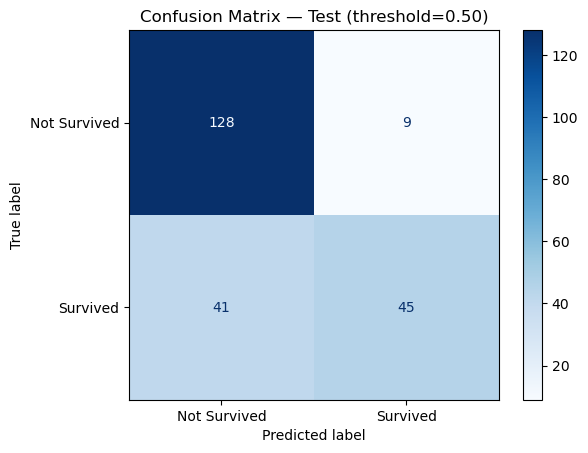

              precision    recall  f1-score   support

Not Survived       0.76      0.93      0.84       137
    Survived       0.83      0.52      0.64        86

    accuracy                           0.78       223
   macro avg       0.80      0.73      0.74       223
weighted avg       0.79      0.78      0.76       223



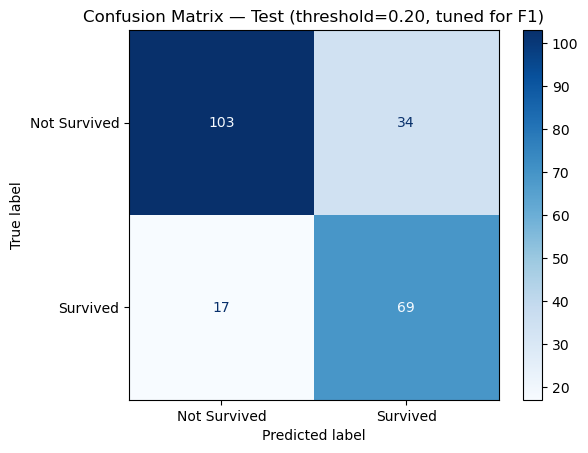

              precision    recall  f1-score   support

Not Survived       0.86      0.75      0.80       137
    Survived       0.67      0.80      0.73        86

    accuracy                           0.77       223
   macro avg       0.76      0.78      0.77       223
weighted avg       0.79      0.77      0.77       223



"\n    Il risulato mostra che la soglia 0.5 ha un'alta precisione ma una bassa sensibilità\n    Con la soglia ottimizzata per F1 (0.3) il modello riduce la precisione.\n    Questa analisi dei trade-off mette in evidenza che la scelta della soglia non è neutra: dipende dal contesto e dagli obiettivi del modello.\n"

In [129]:
"""
    Soglia per massimizzare F1 (su punti con threshold definito)
"""
f1_scores = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = int(np.nanargmax(f1_scores))
best_thr = thr[best_idx]

print(f"\nSoglia ottimizzata per F1: {best_thr:.3f} | Precision={prec[best_idx]:.3f} | Recall={rec[best_idx]:.3f}")

def plot_cm_at_threshold(th, title):
    preds = (proba_test >= th).astype(int)
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm, display_labels=['Not Survived','Survived']).plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title); plt.show()
    print(classification_report(y_test, preds, target_names=['Not Survived','Survived']))

"""
    Confronto la confusione a soglia 0.5 (comportamento standard) vs soglia ottimizzata
"""

plot_cm_at_threshold(0.50, "Confusion Matrix — Test (threshold=0.50)")
plot_cm_at_threshold(best_thr, f"Confusion Matrix — Test (threshold={best_thr:.2f}, tuned for F1)")

"""
    Il risulato mostra che la soglia 0.5 ha un'alta precisione ma una bassa sensibilità
    Con la soglia ottimizzata per F1 (0.3) il modello riduce la precisione.
    Questa analisi dei trade-off mette in evidenza che la scelta della soglia non è neutra: dipende dal contesto e dagli obiettivi del modello.
"""

In [119]:

print("\n--- SINTESI ---")
print(f"Imputazione scelta: {chosen_strategy}")
print(f"max_depth scelto: {chosen_depth}")
print(f"Accuracy Test: {test_acc:.4f} (baseline: {baseline:.4f})")
print("Nota: la PR curve e le confusion matrix a soglia 0.5 vs soglia ottimizzata mostrano il trade-off precision/recall per 'Survived'.")


--- SINTESI ---
Imputazione scelta: median
max_depth scelto: 5
Accuracy Test: 0.7713 (baseline: 0.6168)
Nota: la PR curve e le confusion matrix a soglia 0.5 vs soglia ottimizzata mostrano il trade-off precision/recall per 'Survived'.
